[INFO] Qiskit core version      : 2.1.1
[INFO] qiskit-algorithms version: 0.4.0
[INFO] qiskit-nature version    : 0.7.2


/var/folders/1f/xp49wx494s78pwbz7rqgscp80000gn/T/ipykernel_35754/1709919874.py:278: UserWarning: 두-큐비트 절감 경로를 찾지 못했으므로 ParityMapper만 적용함(감축 없음) → 가능하면 qiskit-nature 버전을 맞춰 두-큐비트 절감을 사용하길 권장함
  warnings.warn(



[Exact FCI] H6 ground-state energy (Hartree) = -9.399185224314
[INFO] FiniteDiffEstimatorGradient 사용 불가 → ADAM은 내부 수치미분/옵션에 의존할 수 있음
[INFO] Ansatz parameters: 36, Qubits(after mapping): 12

=== Running VQE with Rotosolve ===


/var/folders/1f/xp49wx494s78pwbz7rqgscp80000gn/T/ipykernel_35754/1709919874.py:305: DeprecationWarning: The class ``qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.real_amplitudes instead.
  return RealAmplitudes(num_qubits=num_qubits, reps=reps, entanglement="linear")


[Rotosolve] Iter 1/50, Cost = -5.257521
[Rotosolve] Iter 10/50, Cost = -5.307351
[Rotosolve] Iter 20/50, Cost = -4.946826
[Rotosolve] Iter 30/50, Cost = -4.932524
[Rotosolve] Iter 40/50, Cost = -4.489391
[Rotosolve] Iter 50/50, Cost = -4.548167
[Rotosolve] final energy = -4.548167457506  | nfev = 5450

=== Running VQE with SPSA ===
[SPSA] final energy = -7.935772919639  | nfev = 451

=== Running VQE with ADAM ===
[ADAM] final energy = -9.011112708583  | nfev = 7401

=== Running VQE with COBYLA ===
[COBYLA] final energy = -8.281898207949  | nfev = 200

=== Summary ===
Optimizer  Final Energy (Ha)  Abs. Error to Exact (Ha)  nfev (cost calls)
     ADAM    -9.011112708583            0.388072515731               7401
   COBYLA    -8.281898207949            1.117287016365                200
     SPSA    -7.935772919639            1.463412304675                451
Rotosolve    -4.548167457506            4.851017766808               5450


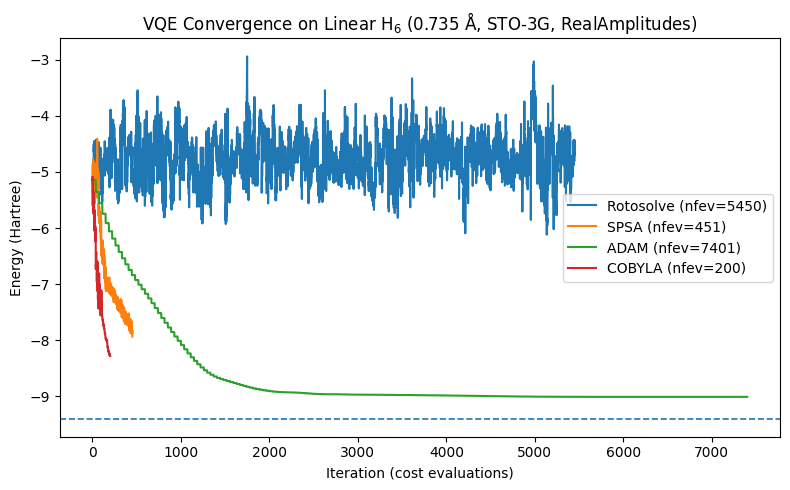

In [2]:
"""
VQE 비교 실험 스크립트 (H6, RealAmplitudes, 버전 호환)
- 목표: H6 분자의 바닥상태 에너지를 VQE로 추정하고, 다양한 옵티마이저의 수렴 특성을 비교
- 분자: H6 (직선형, 인접 원자 간 거리 0.735 Å), basis=STO-3G
- 프리미티브: StatevectorEstimator (이론적 시뮬레이터로 잡음 없음)
- 안자츠: RealAmplitudes(entanglement='linear')
- 매퍼: Parity 기반이며, 버전에 따라 2-qubit reduction 경로가 다를 수 있음
- 옵티마이저: 제공된 Rotosolve, SPSA, ADAM, COBYLA 비교
- 동일 초기 파라미터 사용 및 콜백으로 에너지 이력 기록
- 결과: 표 요약과 수렴 곡선을 하나의 그래프로 그림
"""

# ─────────────────────────────────────────────────────────────────────────────
# [A] 기본 라이브러리 임포트 및 전역 설정 섹션
# ─────────────────────────────────────────────────────────────────────────────

import warnings  # 호환 분기에서 경고 메시지 출력에 사용
import random    # Rotosolve에서 좌표 순서를 섞는 데 사용
import numpy as np
import matplotlib.pyplot as plt

# Qiskit core & algorithms 임포트
import qiskit
# 본 실험은 이상적 시뮬레이터를 사용하므로 StatevectorEstimator를 채택
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.minimum_eigensolvers import VQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA, COBYLA, ADAM

# (선택) 유한차분 기반의 에스티메이터 그래디언트 지원 여부를 확인
try:
    from qiskit_algorithms.gradients import FiniteDiffEstimatorGradient
    _HAS_FD_GRAD = True
except Exception:
    _HAS_FD_GRAD = False

# 전자구조 문제 생성을 위한 qiskit-nature 드라이버를 사용
from qiskit_nature.second_q.drivers import PySCFDriver

# qiskit-nature 버전별 매퍼 경로가 다르므로 분기 준비
_USE_OLD_CONVERTER = False
try:
    # 구버전: QubitConverter가 존재하는 경우
    from qiskit_nature.second_q.mappers import QubitConverter, ParityMapper as _ParityOld
    _USE_OLD_CONVERTER = True
except Exception:
    # 최신: QubitConverter가 제거되고 TaperedQubitMapper가 제공될 수 있음
    from qiskit_nature.second_q.mappers import ParityMapper, TaperedQubitMapper

# ElectronicStructureProblem 생성 경로가 버전에 따라 달라질 수 있으므로 폴백을 준비
try:
    from qiskit_nature.second_q.problems import ElectronicStructureProblem as _ElectronicStructureProblem
except Exception:
    _ElectronicStructureProblem = None


# ─────────────────────────────────────────────────────────────────────────────
# [B] 유틸리티: 버전 정보 출력 함수
# ─────────────────────────────────────────────────────────────────────────────

def _check_versions():
    """사용 중인 Qiskit 및 Nature 버전을 출력함"""
    try:
        core_ver = qiskit.__version__
    except Exception:
        core_ver = "unknown"
    try:
        import qiskit_algorithms
        algo_ver = qiskit_algorithms.__version__
    except Exception:
        algo_ver = "unknown"
    try:
        import qiskit_nature
        nature_ver = qiskit_nature.__version__
    except Exception:
        nature_ver = "unknown"

    print(f"[INFO] Qiskit core version      : {core_ver}")
    print(f"[INFO] qiskit-algorithms version: {algo_ver}")
    print(f"[INFO] qiskit-nature version    : {nature_ver}")

    if not core_ver.startswith("2."):
        warnings.warn("본 스크립트는 Qiskit 2.x에서 검증되었음", UserWarning)
    if "qiskit_algorithms" in globals() and not algo_ver.startswith("0.4"):
        warnings.warn("본 스크립트는 qiskit-algorithms 0.4.x에서 검증되었음", UserWarning)


# ─────────────────────────────────────────────────────────────────────────────
# [C] 제공된 Rotosolve 구현체 섹션임 (문제에서 반드시 이 구현을 사용해야 함)
# ─────────────────────────────────────────────────────────────────────────────

class Rotosolve:
    """좌표별 해석적 라인 서치를 수행하는 Rotosolve 최적화기 구현체임"""

    def __init__(self, maxiter=50, tol=1e-8, repeats=1):
        self.maxiter = maxiter
        self.tol = tol
        self.history = []   # 각 반복에서의 비용(에너지) 기록용
        self.repeats = repeats  # 현재 구현에서는 사용하지 않지만 API 호환을 위해 유지

    @staticmethod
    def _wrap_angle(x):
        """각도를 [-π, π) 구간으로 감싸 numerical 안정성을 높임"""
        return (x + np.pi) % (2 * np.pi) - np.pi

    def optimize(self, init_params, cost_fn):
        """좌표강하 + 해석적 라인서치로 파라미터를 최적화"""
        params = np.array(init_params, dtype=float)
        D = params.size

        for it in range(self.maxiter):
            max_delta = 0.0
            indices = list(range(D))
            random.shuffle(indices)  # 좌표 순서를 섞어 편향을 줄임

            for i in indices:
                theta_i = params[i]

                # 3점 샘플을 준비함: 현재점, +π/2, -π/2
                base  = params.copy()
                plus  = params.copy(); plus[i]  += np.pi/2
                minus = params.copy(); minus[i] -= np.pi/2

                # 가능한 경우 배치 평가를 활용
                batched = np.vstack([base, plus, minus])  # 모양: (3, D)
                try:
                    vals = cost_fn(batched)  # 길이 3의 결과를 기대
                    vals = np.asarray(vals, dtype=float).ravel()
                    if vals.shape[0] != 3:
                        raise ValueError("batch output must be length 3")
                    E0, Ep, Em = vals
                except Exception:
                    # 배치 평가가 불가하면 개별 평가를 수행
                    E0 = float(cost_fn(base))
                    Ep = float(cost_fn(plus))
                    Em = float(cost_fn(minus))

                # 단일 주파수 가정 하에서의 해석적 최적 각도를 계산
                a = np.arctan2(2.0 * E0 - Ep - Em, Ep - Em)
                theta_opt = -np.pi/2 - a
                theta_opt = self._wrap_angle(theta_opt)

                # 갱신 폭을 기록하고 파라미터를 업데이트
                delta = np.abs(self._wrap_angle(theta_opt - theta_i))
                max_delta = max(max_delta, delta)
                params[i] = theta_opt

            # 한 스윕 이후 비용을 기록
            cost = float(cost_fn(params))
            self.history.append(cost)

            if (it == 0) or ((it + 1) % 10 == 0):
                print(f"[Rotosolve] Iter {it+1}/{self.maxiter}, Cost = {cost:.6f}")

            # 모든 좌표의 갱신 폭이 tol보다 작다면 수렴했다고 판단
            if max_delta < self.tol:
                break

        return params, cost


# ─────────────────────────────────────────────────────────────────────────────
# [D] Rotosolve를 Qiskit Optimizer 인터페이스로 감싸는 래퍼 섹션
# ─────────────────────────────────────────────────────────────────────────────

from qiskit_algorithms.optimizers import (
    Optimizer,
    OptimizerResult,
    OptimizerSupportLevel,
)

class RotosolveWrapper(Optimizer):
    """VQE가 기대하는 Optimizer 인터페이스(minimize 등)를 제공하는 래퍼"""

    def __init__(self, maxiter=50, tol=1e-8, repeats=1):
        super().__init__()
        self._rotosolve = Rotosolve(maxiter=maxiter, tol=tol, repeats=repeats)
        self._nfev = 0  # 비용 함수 평가 횟수를 집계

    @property
    def settings(self):
        """옵티마이저 메타데이터를 반환"""
        return {
            "name": "RotosolveWrapper",
            "maxiter": self._rotosolve.maxiter,
            "tol": self._rotosolve.tol,
            "repeats": self._rotosolve.repeats,
        }

    # Optimizer 추상 메서드 구현임
    def get_support_level(self):
        """해당 옵티마이저가 지원하는 입력 정보 알림"""
        # gradient/bounds는 사용하지 않고, initial_point는 필요
        return {
            "gradient": OptimizerSupportLevel.ignored,
            "bounds": OptimizerSupportLevel.ignored,
            "initial_point": OptimizerSupportLevel.required,
        }

    def minimize(self, fun, x0, jac=None, bounds=None):
        """VQE가 호출하는 최소화 루틴 (SciPy 인터페이스 유사)"""
        self._nfev = 0

        # VQE의 fun은 1차원 배열 -> 스칼라 에너지값을 반환
        # Rotosolve는 1D/2D 입력을 모두 받도록 브리지를 구성
        def bridge(theta):
            x = np.asarray(theta, dtype=float)
            if x.ndim == 1:
                self._nfev += 1
                return float(fun(x))
            elif x.ndim == 2:
                vals = []
                for row in x:
                    self._nfev += 1
                    vals.append(float(fun(row)))
                return np.array(vals, dtype=float)
            else:
                raise ValueError("theta must be 1D or 2D array")

        x_opt, f_opt = self._rotosolve.optimize(x0, bridge)

        # Qiskit OptimizerResult로 결과 정리
        result = OptimizerResult()
        result.x = np.asarray(x_opt, dtype=float)
        result.fun = float(f_opt)
        result.nfev = int(self._nfev)
        result.nit = len(self._rotosolve.history)
        result.optimizer_time = None
        result._metadata = {"name": "RotosolveWrapper"}
        return result

    # 구버전 API 호환을 위해 optimize도 제공
    def optimize(self, num_vars, objective_function, initial_point):
        res = self.minimize(objective_function, initial_point)
        return res.x, res.fun, res.nfev


# ─────────────────────────────────────────────────────────────────────────────
# [E] 전자구조 해밀토니안 생성 및 매핑 섹션임
# ─────────────────────────────────────────────────────────────────────────────

def build_h6_qubit_hamiltonian(bond_length=0.735):
    """직선형 H6 분자의 해밀토니안을 생성하고 큐비트 연산자로 매핑"""
    # z축으로 등간격 배치함 (0, 0, k*bond_length), k = 0..5 임
    geom = "; ".join([f"H 0 0 {i * bond_length}" for i in range(6)])
    driver = PySCFDriver(atom=geom, basis="sto3g", charge=0, spin=0)

    # 최신 API에서는 driver.run()이 ElectronicStructureProblem을 반환
    try:
        problem = driver.run()
    except Exception:
        # 아주 구버전에서는 ElectronicStructureProblem(driver) 방식이 필요할 수 있음
        if _ElectronicStructureProblem is None:
            raise
        problem = _ElectronicStructureProblem(driver)

    # 2차 양자화 해밀토니안을 얻음
    second_q_op = problem.hamiltonian.second_q_op()

    # ── 경로 1: QubitConverter가 있는 구버전이면 two_qubit_reduction을 활용
    if _USE_OLD_CONVERTER:
        mapper = _ParityOld()
        converter = QubitConverter(mapper=mapper, two_qubit_reduction=True)
        qubit_op: SparsePauliOp = converter.convert(
            second_q_op, num_particles=problem.num_particles
        )
        return qubit_op, problem

    # ── 경로 2: 최신 버전에서 symmetry_sector_locator가 제공되면 TaperedQubitMapper로 감축
    if 'TaperedQubitMapper' in globals() and hasattr(problem, "symmetry_sector_locator"):
        tapered_mapper = TaperedQubitMapper(ParityMapper(), problem.symmetry_sector_locator)
        qubit_op: SparsePauliOp = tapered_mapper.map(second_q_op)
        return qubit_op, problem

    # ── 경로 3: 위 두 경로가 불가하면 ParityMapper만 적용(감축 없음)
    warnings.warn(
        "두-큐비트 절감 경로를 찾지 못했으므로 ParityMapper만 적용함(감축 없음) "
        "→ 가능하면 qiskit-nature 버전을 맞춰 두-큐비트 절감을 사용하길 권장함",
        UserWarning
    )
    mapper = ParityMapper() if 'ParityMapper' in globals() else _ParityOld()
    qubit_op: SparsePauliOp = mapper.map(second_q_op)
    return qubit_op, problem


# ─────────────────────────────────────────────────────────────────────────────
# [F] 기준치(정확 해) 계산 유틸 섹션
# ─────────────────────────────────────────────────────────────────────────────

def exact_ground_energy(qubit_op: SparsePauliOp):
    """NumPyMinimumEigensolver로 참 바닥상태 에너지를 계산(FCI 기준)"""
    exact_solver = NumPyMinimumEigensolver()
    res = exact_solver.compute_minimum_eigenvalue(qubit_op)
    return float(np.real(res.eigenvalue))


# ─────────────────────────────────────────────────────────────────────────────
# [G] 안자츠 생성 및 VQE 실행 유틸 섹션
# ─────────────────────────────────────────────────────────────────────────────

def make_ansatz(num_qubits: int, reps: int = 1):
    """RealAmplitudes 안자츠를 생성(linear 얽힘, reps는 레이어 수를 의미함)"""
    return RealAmplitudes(num_qubits=num_qubits, reps=reps, entanglement="linear")


def run_vqe_experiment(qubit_op, ansatz, optimizer, init_point, name, estimator, gradient=None):
    """단일 옵티마이저에 대해 VQE를 실행하고, 콜백으로 에너지 이력을 수집"""
    energy_trace = []

    # VQE 콜백은 보통 (eval_count, parameters, mean, std/metadata) 형태
    def callback(*args):
        if len(args) >= 3:
            energy = args[2]
            energy_trace.append(float(np.real(energy)))

    vqe = VQE(
        estimator=estimator,
        ansatz=ansatz,
        optimizer=optimizer,
        initial_point=init_point,
        gradient=gradient,  # SPSA/COBYLA에는 무시되고 ADAM에서 유용할 수 있음
        callback=callback
    )
    res = vqe.compute_minimum_eigenvalue(qubit_op)

    nfev = len(energy_trace)              # 콜백 호출 횟수를 비용 함수 평가 횟수로 간주
    final_energy = float(np.real(res.eigenvalue))

    return {
        "name": name,
        "result": res,
        "energy_trace": energy_trace,
        "final_energy": final_energy,
        "nfev": nfev
    }


# ─────────────────────────────────────────────────────────────────────────────
# [H] 메인 루틴 섹션임: 전체 비교 실험을 순서대로 수행
# ─────────────────────────────────────────────────────────────────────────────

def main():
    _check_versions()  # 버전 정보를 출력하여 호환성을 점검

    # (1) 전자구조 해밀토니안 생성 및 정확 에너지 계산
    qubit_op, problem = build_h6_qubit_hamiltonian(bond_length=0.735)
    exact_e = exact_ground_energy(qubit_op)
    print(f"\n[Exact FCI] H6 ground-state energy (Hartree) = {exact_e:.12f}")

    # (2) 프리미티브/그래디언트 준비
    estimator = Estimator()  # Statevector 기반의 이상적 에스티메이터
    gradient = None
    if _HAS_FD_GRAD:
        # 가능한 경우 유한차분 그래디언트를 설정
        try:
            gradient = FiniteDiffEstimatorGradient(estimator)
        except Exception:
            gradient = None
    if gradient is None:
        print("[INFO] FiniteDiffEstimatorGradient 사용 불가 → ADAM은 내부 수치미분/옵션에 의존할 수 있음")

    # (3) 안자츠와 공통 초기 파라미터를 준비
    num_qubits = qubit_op.num_qubits
    ansatz = make_ansatz(num_qubits=num_qubits, reps=2)
    rng = np.random.default_rng(42)  # 재현성을 위한 시드 고정
    init_point = rng.uniform(-np.pi, np.pi, ansatz.num_parameters)
    print(f"[INFO] Ansatz parameters: {ansatz.num_parameters}, Qubits(after mapping): {num_qubits}")

    # (4) 비교할 옵티마이저를 정의함 (동일 초기점으로 공정 비교)
    optimizers = [
        ("Rotosolve", RotosolveWrapper(maxiter=50, tol=1e-8)),
        ("SPSA",      SPSA(maxiter=200)),
        ("ADAM",      ADAM(maxiter=200, lr=0.05)),
        ("COBYLA",    COBYLA(maxiter=200))
    ]

    # (5) 각 옵티마이저로 VQE를 실행하고 로그를 수집
    all_results = []
    for name, opt in optimizers:
        print(f"\n=== Running VQE with {name} ===")
        res = run_vqe_experiment(
            qubit_op=qubit_op,
            ansatz=ansatz,
            optimizer=opt,
            init_point=init_point,
            name=name,
            estimator=estimator,
            gradient=gradient
        )
        print(f"[{name}] final energy = {res['final_energy']:.12f}  | nfev = {res['nfev']}")
        all_results.append(res)

    # (6) 결과 요약 표를 출력
    import pandas as pd
    rows = []
    for r in all_results:
        err = abs(r["final_energy"] - exact_e)
        rows.append({
            "Optimizer": r["name"],
            "Final Energy (Ha)": r["final_energy"],
            "Abs. Error to Exact (Ha)": err,
            "nfev (cost calls)": r["nfev"]
        })
    df = pd.DataFrame(rows).sort_values(by="Final Energy (Ha)")
    print("\n=== Summary ===")
    print(df.to_string(index=False, float_format=lambda x: f"{x:.12f}"))

    # (7) 수렴 그래프
    plt.figure(figsize=(8, 5))
    for r in all_results:
        y = r["energy_trace"]
        x = np.arange(1, len(y) + 1)
        label = f"{r['name']} (nfev={r['nfev']})"
        plt.plot(x, y, label=label)
    plt.axhline(exact_e, linestyle="--", linewidth=1.2)  # 참값을 점선으로 표시
    plt.title("VQE Convergence on Linear H$_6$ (0.735 Å, STO-3G, RealAmplitudes)")
    plt.xlabel("Iteration (cost evaluations)")
    plt.ylabel("Energy (Hartree)")
    plt.legend()
    plt.tight_layout()
    plt.show()


# ─────────────────────────────────────────────────────────────────────────────
# [I] 스크립트 엔트리포인트 섹션
# ─────────────────────────────────────────────────────────────────────────────

if __name__ == "__main__":
    main()